In [1]:
import findspark
findspark.init()
import pyspark
print(pyspark.__file__)

C:\Spark\spark-3.5.1-bin-hadoop3\python\pyspark\__init__.py


In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Customer_Segiment").getOrCreate()

# Đọc File

In [3]:
file_path = 'Products_with_Categories.csv'
df_Products = spark.read.csv(file_path, header=True, inferSchema=True)
df_Products.show(5)

+---------+----------------+-----+---------------+
|productId|     productName|price|       Category|
+---------+----------------+-----+---------------+
|        1|  tropical fruit|  7.8|     Fresh Food|
|        2|      whole milk|  1.8|          Dairy|
|        3|       pip fruit|  3.0|     Fresh Food|
|        4|other vegetables|  0.8|     Fresh Food|
|        5|      rolls/buns|  1.2|Bakery & Sweets|
+---------+----------------+-----+---------------+
only showing top 5 rows



In [4]:
file_path_2 = 'Transactions.csv'
df_Transactions = spark.read.csv(file_path_2, header=True, inferSchema=True)
df_Transactions.show(5)

+-------------+----------+---------+-----+
|Member_number|      Date|productId|items|
+-------------+----------+---------+-----+
|         1808|21-07-2015|        1|    3|
|         2552|05-01-2015|        2|    1|
|         2300|19-09-2015|        3|    3|
|         1187|12-12-2015|        4|    3|
|         3037|01-02-2015|        2|    1|
+-------------+----------+---------+-----+
only showing top 5 rows



In [5]:
df = df_Transactions.join(df_Products, on="productId", how="inner")
df.show(5)

+---------+-------------+----------+-----+----------------+-----+----------+
|productId|Member_number|      Date|items|     productName|price|  Category|
+---------+-------------+----------+-----+----------------+-----+----------+
|        1|         1808|21-07-2015|    3|  tropical fruit|  7.8|Fresh Food|
|        2|         2552|05-01-2015|    1|      whole milk|  1.8|     Dairy|
|        3|         2300|19-09-2015|    3|       pip fruit|  3.0|Fresh Food|
|        4|         1187|12-12-2015|    3|other vegetables|  0.8|Fresh Food|
|        2|         3037|01-02-2015|    1|      whole milk|  1.8|     Dairy|
+---------+-------------+----------+-----+----------------+-----+----------+
only showing top 5 rows



# EDA

In [6]:
print("Schema: ")
df.printSchema()

print("Thống kê mô tả: ")
df.describe().show()

Schema: 
root
 |-- productId: integer (nullable = true)
 |-- Member_number: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- items: integer (nullable = true)
 |-- productName: string (nullable = true)
 |-- price: double (nullable = true)
 |-- Category: string (nullable = true)

Thống kê mô tả: 
+-------+------------------+------------------+----------+------------------+--------------------+-----------------+--------------------+
|summary|         productId|     Member_number|      Date|             items|         productName|            price|            Category|
+-------+------------------+------------------+----------+------------------+--------------------+-----------------+--------------------+
|  count|             38765|             38765|     38765|             38765|               38765|            38765|               38765|
|   mean| 39.95609441506514|  3003.64186766413|      NULL| 1.996130530117374|                NULL| 4.29517038565748|                NU

### Xử lý Null và NaN

In [7]:
from pyspark.sql.functions import col, isnan, when, count

df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()


+---------+-------------+----+-----+-----------+-----+--------+
|productId|Member_number|Date|items|productName|price|Category|
+---------+-------------+----+-----+-----------+-----+--------+
|        0|            0|   0|    0|          0|    0|       0|
+---------+-------------+----+-----+-----------+-----+--------+



In [8]:
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+---------+-------------+----+-----+-----------+-----+--------+
|productId|Member_number|Date|items|productName|price|Category|
+---------+-------------+----+-----+-----------+-----+--------+
|        0|            0|   0|    0|          0|    0|       0|
+---------+-------------+----+-----+-----------+-----+--------+



### Chuyển cột Date từ string sang Date

In [9]:
from pyspark.sql.functions import to_date
df = df.withColumn("Date", to_date(df["Date"], "dd-MM-yyyy"))
df.show(5)

+---------+-------------+----------+-----+----------------+-----+----------+
|productId|Member_number|      Date|items|     productName|price|  Category|
+---------+-------------+----------+-----+----------------+-----+----------+
|        1|         1808|2015-07-21|    3|  tropical fruit|  7.8|Fresh Food|
|        2|         2552|2015-01-05|    1|      whole milk|  1.8|     Dairy|
|        3|         2300|2015-09-19|    3|       pip fruit|  3.0|Fresh Food|
|        4|         1187|2015-12-12|    3|other vegetables|  0.8|Fresh Food|
|        2|         3037|2015-02-01|    1|      whole milk|  1.8|     Dairy|
+---------+-------------+----------+-----+----------------+-----+----------+
only showing top 5 rows



In [10]:
from pyspark.sql.functions import min, max

earliest_date = df.select(min("Date")).collect()[0][0]
print(f"Thời điểm dữ liệu bắt đầu được ghi nhận: {earliest_date}")

latest_date = df.select(max("Date")).collect()[0][0]
print(f"Thời điểm dữ liệu kết thúc được ghi nhận: {latest_date}")

Thời điểm dữ liệu bắt đầu được ghi nhận: 2014-01-01
Thời điểm dữ liệu kết thúc được ghi nhận: 2015-12-30


In [11]:
product_type = df.select("Category").distinct().count()
print(f"Số loại sản phẩm: {product_type}")

product_name = df.select("productName").distinct().count()
print(f"Số tên sản phẩm: {product_name}")

Số loại sản phẩm: 11
Số tên sản phẩm: 167


In [12]:
from pyspark.sql.functions import sum, col, desc, round

# Tổng số sản phẩm đã bán
total_items_sold = df.select(sum("items")).collect()[0][0]

# Tính tổng số lượng bán của từng sản phẩm và phần trăm so với tổng
top_products = (
    df.groupBy("productName")
    .agg(sum("items").alias("total_sold"))
    .withColumn("percentage", round((col("total_sold") / total_items_sold) * 100, 2))
    .orderBy(desc("total_sold"))
)

print("Trong tổng số 167 sản phẩm thì sữa là sản phẩm có tỉ lệ bán chạy cao nhất lên đến 6.54%: ")
top_products.show(5)  # Hiển thị top 10 sản phẩm bán chạy nhất

Trong tổng số 167 sản phẩm thì sữa là sản phẩm có tỉ lệ bán chạy cao nhất lên đến 6.54%: 
+----------------+----------+----------+
|     productName|total_sold|percentage|
+----------------+----------+----------+
|      whole milk|      5059|      6.54|
|other vegetables|      3787|      4.89|
|      rolls/buns|      3373|      4.36|
|            soda|      3004|      3.88|
|          yogurt|      2674|      3.46|
+----------------+----------+----------+
only showing top 5 rows



In [13]:
type_items_sold = (
    df.groupBy("Category")
    .agg(sum("items").alias("total_sold"))
    .withColumn("percentage", round((col("total_sold") / total_items_sold) * 100, 2))
    .orderBy(desc("total_sold"))
)

print("Trong tổng số 11 loại sản phẩm thì thực phẩm tươi là loại sản phẩm có tỉ lệ bán chạy cao nhất lên đến 29.63%: ")
type_items_sold.show()  # Hiển thị top 10 sản phẩm

Trong tổng số 11 loại sản phẩm thì thực phẩm tươi là loại sản phẩm có tỉ lệ bán chạy cao nhất lên đến 29.63%: 
+--------------------+----------+----------+
|            Category|total_sold|percentage|
+--------------------+----------+----------+
|          Fresh Food|     22927|     29.63|
|               Dairy|     15115|     19.53|
|           Beverages|     12030|     15.55|
|     Bakery & Sweets|     11867|     15.34|
| Household & Hygiene|      4357|      5.63|
|Frozen & Processe...|      3695|      4.78|
|      Pantry Staples|      3138|      4.06|
|Specialty & Seasonal|      2368|      3.06|
|              Snacks|       930|       1.2|
|            Pet Care|       641|      0.83|
|       Personal Care|       312|       0.4|
+--------------------+----------+----------+



In [14]:
from pyspark.sql.functions import countDistinct, sum

# Tổng số khách hàng duy nhất
total_customers = df.select(countDistinct("Member_number")).collect()[0][0]

# Tổng số sản phẩm đã bán
total_products_sold = df.select(sum("items")).collect()[0][0]

# Tổng doanh thu
total_price = df.select(sum(col("price") * col("items"))).collect()[0][0]


print(f"Tổng số khách hàng đã ghé: {total_customers}")
print(f"Tổng số sản phẩm đã bán được: {total_products_sold}")
print(f"Tổng doanh thu của cửa hàng: {total_price}")

Tổng số khách hàng đã ghé: 3898
Tổng số sản phẩm đã bán được: 77380
Tổng doanh thu của cửa hàng: 332159.6299999853


In [15]:
from pyspark.sql.functions import year, month, concat, lit, sum

# Lọc dữ liệu năm 2014
monthly_sales_2014 = df.filter(year("Date") == 2014)

# Tạo cột Date dạng YYYY-MM
monthly_sales_2014 = monthly_sales_2014.withColumn("Date", concat(year("Date"), lit("-"), month("Date")))

# Tính tổng số sản phẩm bán theo Date
monthly_sales_2014 = monthly_sales_2014.groupBy("Date") \
                        .agg(sum("items").alias("Total_Items_Sold")) \
                        .orderBy("Total_Items_Sold", ascending=False)
monthly_sales_2014.show()


+-------+----------------+
|   Date|Total_Items_Sold|
+-------+----------------+
| 2014-5|            3266|
|2014-10|            3204|
| 2014-7|            3158|
| 2014-6|            3112|
| 2014-8|            3104|
| 2014-1|            3091|
| 2014-4|            3074|
|2014-12|            2975|
|2014-11|            2946|
| 2014-9|            2945|
| 2014-2|            2829|
| 2014-3|            2791|
+-------+----------------+



In [16]:
from pyspark.sql.functions import year, month, concat, lit, sum

# Lọc dữ liệu năm 2014
monthly_sales_2015 = df.filter(year("Date") == 2015)

# Tạo cột Date dạng YYYY-MM
monthly_sales_2015 = monthly_sales_2015.withColumn("Date", concat(year("Date"), lit("-"), month("Date")))

# Tính tổng số sản phẩm bán theo Date
monthly_sales_2015 = monthly_sales_2015.groupBy("Date") \
                        .agg(sum("items").alias("Total_Items_Sold")) \
                        .orderBy("Total_Items_Sold", ascending=False)
monthly_sales_2015.show()

+-------+----------------+
|   Date|Total_Items_Sold|
+-------+----------------+
| 2015-8|            3846|
| 2015-1|            3630|
| 2015-5|            3596|
|2015-11|            3547|
| 2015-7|            3442|
| 2015-3|            3420|
| 2015-6|            3383|
| 2015-4|            3375|
|2015-10|            3313|
| 2015-9|            3162|
| 2015-2|            3125|
|2015-12|            3046|
+-------+----------------+



### RFM

In [17]:
from pyspark.sql.functions import col, datediff, count, sum, max, lit

# Xác định ngày gần nhất trong dataset
max_date = df.select(max(col("Date"))).collect()[0][0]

# Tính toán RFM
rfm_df = df.groupBy("Member_number").agg(
    datediff(lit(max_date), max(col("Date"))).alias("Recency"),  # Ngày gần nhất mua hàng
    count("productId").alias("Frequency"),  # Số lần mua hàng
    round(sum(col("price") * col("items")), 2).alias("Monetary")  # Tổng tiền đã chi tiêu
)

rfm_df.show(5)

+-------------+-------+---------+--------+
|Member_number|Recency|Frequency|Monetary|
+-------------+-------+---------+--------+
|         1959|     17|       19|   160.6|
|         1088|     30|        9|   58.75|
|         4818|    285|        8|    43.5|
|         2659|     22|       16|  172.97|
|         1580|     25|       16|   53.35|
+-------------+-------+---------+--------+
only showing top 5 rows



In [18]:
num_entries = rfm_df.count()
print(f"Số entries (Khách Hàng): {num_entries}")
num_attributes = len(rfm_df.columns)
print(f"Số attributes: {num_attributes}")


Số entries (Khách Hàng): 3898
Số attributes: 4


In [19]:
rfm_df = rfm_df.sort("Monetary", ascending = False)
rfm_df.show(5)

+-------------+-------+---------+--------+
|Member_number|Recency|Frequency|Monetary|
+-------------+-------+---------+--------+
|         2433|      3|       31|  375.31|
|         2193|     91|       27|  361.45|
|         1793|     26|       25|   345.1|
|         3289|      4|       29|  334.15|
|         2743|    142|       17|  312.46|
+-------------+-------+---------+--------+
only showing top 5 rows



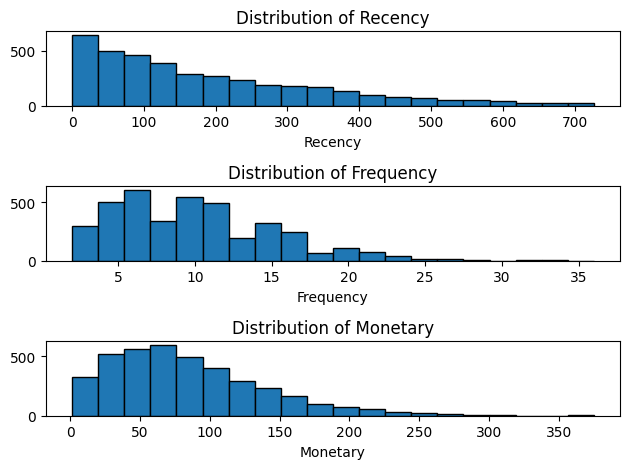

In [20]:
import matplotlib.pyplot as plt

# Chuyển đổi DataFrame PySpark thành Pandas
rfm_pd = rfm_df.toPandas()

# Vẽ phân phối của 'Recency'
plt.subplot(3, 1, 1)  # 3 hàng, 1 cột, vị trí thứ nhất
plt.hist(rfm_pd['Recency'], bins=20, edgecolor='black')
plt.title('Distribution of Recency')
plt.xlabel('Recency')

# Vẽ phân phối của 'Frequency'
plt.subplot(3, 1, 2)  # 3 hàng, 1 cột, vị trí thứ hai
plt.hist(rfm_pd['Frequency'], bins=20, edgecolor='black')
plt.title('Distribution of Frequency')
plt.xlabel('Frequency')

# Vẽ phân phối của 'Monetary'
plt.subplot(3, 1, 3)  # 3 hàng, 1 cột, vị trí thứ ba
plt.hist(rfm_pd['Monetary'], bins=20, edgecolor='black')
plt.title('Distribution of Monetary')
plt.xlabel('Monetary')

plt.tight_layout()
plt.show()


In [21]:
from pyspark.sql.functions import col, when
from pyspark.sql import Window
# Xác định nhãn cho R, F, M
r_labels = [4, 3, 2, 1]  # Recency: nhỏ hơn thì điểm cao hơn
f_labels = [1, 2, 3, 4]  # Frequency: lớn hơn thì điểm cao hơn
m_labels = [1, 2, 3, 4]  # Monetary: lớn hơn thì điểm cao hơn

# Hàm gán điểm RFM
def assign_rfm_labels(df, column, labels, new_column_name):
    quantiles = df.approxQuantile(column, [0.25, 0.5, 0.75], 0)
    return df.withColumn(
        new_column_name,
        when(col(column) <= quantiles[0], labels[0])
        .when(col(column) <= quantiles[1], labels[1])
        .when(col(column) <= quantiles[2], labels[2])
        .otherwise(labels[3])
    )

# Áp dụng cho từng cột
rfm_df = assign_rfm_labels(rfm_df, "Recency", r_labels, "R")
rfm_df = assign_rfm_labels(rfm_df, "Frequency", f_labels, "F")
rfm_df = assign_rfm_labels(rfm_df, "Monetary", m_labels, "M")

# Hiển thị kết quả
rfm_df.show(5)


+-------------+-------+---------+--------+---+---+---+
|Member_number|Recency|Frequency|Monetary|  R|  F|  M|
+-------------+-------+---------+--------+---+---+---+
|         2433|      3|       31|  375.31|  4|  4|  4|
|         2193|     91|       27|  361.45|  3|  4|  4|
|         1793|     26|       25|   345.1|  4|  4|  4|
|         3289|      4|       29|  334.15|  4|  4|  4|
|         2743|    142|       17|  312.46|  2|  4|  4|
+-------------+-------+---------+--------+---+---+---+
only showing top 5 rows



In [22]:
rfm_pandas = rfm_df.toPandas()
rfm_pandas.to_csv("rfm_output.csv", index=False)

In [23]:
df = df_Transactions.join(df_Products, on="productId", how="inner")
df.show(5)

+---------+-------------+----------+-----+----------------+-----+----------+
|productId|Member_number|      Date|items|     productName|price|  Category|
+---------+-------------+----------+-----+----------------+-----+----------+
|        1|         1808|21-07-2015|    3|  tropical fruit|  7.8|Fresh Food|
|        2|         2552|05-01-2015|    1|      whole milk|  1.8|     Dairy|
|        3|         2300|19-09-2015|    3|       pip fruit|  3.0|Fresh Food|
|        4|         1187|12-12-2015|    3|other vegetables|  0.8|Fresh Food|
|        2|         3037|01-02-2015|    1|      whole milk|  1.8|     Dairy|
+---------+-------------+----------+-----+----------------+-----+----------+
only showing top 5 rows



In [24]:
df = df.toPandas()
df.to_csv("dataframe_total.csv", index = False)

In [39]:
# 1. Tổng số lượng bán cho từng sản phẩm
df_product_sales = df.groupby(["productName", "productId"])["items"].sum().reset_index(name="counts")
df_product_sales.to_csv("df_product_sales.csv", index=False)
# 2. Tổng số lượng theo Category
df_category_sales = df.groupby("Category")["items"].sum().reset_index(name="count_cat")
df_category_sales.to_csv("df_category_sales.csv", index=False)